In [62]:
__author__ = "me"
__date__ = "2015_10_13"
%pylab inline
import pandas as pd
# import numpy as np
# import geopandas as gp

from sklearn.linear_model import LinearRegression
import pylab as plt
import os

from palettable.colorbrewer.qualitative import Paired_11

import requests
s = requests.get("https://raw.githubusercontent.com/Casyfill/CUSP_templates/master/Py/fbMatplotlibrc.json").json()
plt.rcParams.update(s)


PWD = os.getenv('PWD')

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [4]:
### automatically gets all dataframes from 'finished_data' folder, 
### so you can add more files and run code withoit
### any chage


def getAllFinished(mypath):
    cols = ['ID',
            'category',
            'checkIns',
            'createdAt',
            'description',
            'genCategory',
            'lat','lon',
            'name',
            'photoCount',
            'price',
            'query','rating',
            'tags','tileID',
            'time','tips',
            'users','verified']
    
    files = [ f for f in os.listdir(mypath) if (os.path.isfile(os.path.join(mypath,f)) and ('.csv' in f)) ]
#     print files
    return {k.replace('.csv',''):pd.read_csv(os.path.join(mypath,k),encoding='utf8')[cols] for k in files}

In [5]:
dfs = getAllFinished('/Users/casy/Dropbox/CUSP/project/Square_cities/data/finished_data/')

/Users/casy/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3066: DtypeWarning: Columns (1,3,4,5,7,8,10,11,13,14,15,18) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


-----------

# Aggregating by category

In [11]:
def aggData(df):
    cats = df.groupby('category').agg({'genCategory':lambda x: x.iloc[0],"checkIns":sum,'tips':sum, 'users':sum,'photoCount':sum})
    return cats.reset_index()

In [12]:
tokyo_cat = aggData(dfs['Tokyo'])
tokyo_cat.head(5)

,category,tips,photoCount,checkIns,genCategory,users
0,ATM,7,40,3122,Shop & Service,659
1,Acai House,4,95,441,Food,210
2,Accessories Store,71,1038,9602,Shop & Service,5781
3,Acupuncturist,16,22,1193,Professional & Other Places,147
4,Adult Boutique,18,109,5622,Shop & Service,2282


## PLOTTING

In [20]:
# tokyo_cat.checkIns.describe()
len(tokyo_cat[pd.isnull(tokyo_cat.checkIns)])

0

In [60]:
def getLinears(df):
    '''return linear model'''
    lm = LinearRegression()
    X = np.reshape(df.checkIns, (len(df),1))
    y = np.reshape(df.users, (len(df),1))
    lm.fit(X,y)
    return lm, X

def getLogLinears(df, cf=True):
    '''return linear model'''
    lm = LinearRegression()
    X = np.reshape(np.log10(df.checkIns[df.checkIns>0]), (len(df[df.checkIns>0]),1))
    y = np.reshape(np.log10(df.users[df.users>0]), (len(df[df.users>0]),1))
    
    lm.fit(X,y)
    if cf:
        # The coefficients
        print('Coefficients: \n', lm.coef_)
        # The mean square error
        print("Residual sum of squares: %.2f" % np.mean((lm.predict(X) - y) ** 2))
        # Explained variance score: 1 is perfect prediction
        print('Variance score: %.2f' % lm.score(X, y))
    return lm, X, y

In [28]:
def annotate_plot(frame, label_col, plot_col1,plot_col2, **kwargs):
    for label, x, y in zip(frame[label_col], frame[plot_col1], frame[plot_col2]):
        plt.annotate(label, xy=(x, y), **kwargs)

In [29]:
def plotCats(data,tname, save=False):
    df = aggData(data)
    myLm, X = getLinears(df)
    groups = df.groupby('genCategory')

    fig, ax = plt.subplots(figsize=(10,10))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling


    for name, group in groups:
        ax.plot(group.checkIns, group.users, marker='o',  linestyle='', ms=6, alpha=.4, label=name)
        annotate_plot(group[(group.users > 0.5*ax.get_ylim()[1])|(group.checkIns > 0.35*ax.get_xlim()[1])], 'category', 'checkIns', 'users',fontsize=12)

    ax.plot((0,ax.get_ylim()[1]), (0,ax.get_ylim()[1]), color='r', linestyle='--', linewidth=.6,  label='1:1 axis')
    ax.plot(X, myLm.predict(X), color='blue',linestyle='-', linewidth=.3, label='lm') 

    plt.ylabel('users')    
    plt.xlabel('checkins')    
    plt.title('%s, Users vs check Ins per category'%tname, fontsize=14)
    ax.legend(numpoints=1,loc='best');
    if save:
        plt.savefig(PWD + '/img/Scatterplots/normal_scatter/%s_cat_sctplt.pdf'%tname)


In [30]:
# for k, v in dfs.iteritems(): plotCats(v,k, save=1)

In [75]:
def plotLog(df, dfname):
    groups = df.groupby('genCategory')
    
    myLm, X, y = getLogLinears(df)
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling


    for name, group in groups:
        ax.plot(np.log10(group.checkIns), np.log10(group.users), marker='o',  linestyle='', ms=6, alpha=.4, label=name)
#         annotate_plot(group[group.users >500000], 'category', 'checkIns', 'users')

    ax.plot((0,7), (0,7), color='r', linestyle='--', linewidth=.6,  label='1:1 axis') ## equality axis
    ax.plot(X, myLm.predict(X), color='blue',linestyle='-', linewidth=.3, label='lm') 
    
    plt.ylabel('users, log')    
    plt.xlabel('checkins, log')    
    plt.title('%s, Users vs check Ins per category, log'% dfname)
    ax.legend(numpoints=1,loc='best');
    plt.savefig(PWD + '/img/%s_cat_sctplt_lat.png' % dfname)


('Coefficients: \n', array([[ 0.95745464]]))
Residual sum of squares: 0.07
Variance score: 0.96


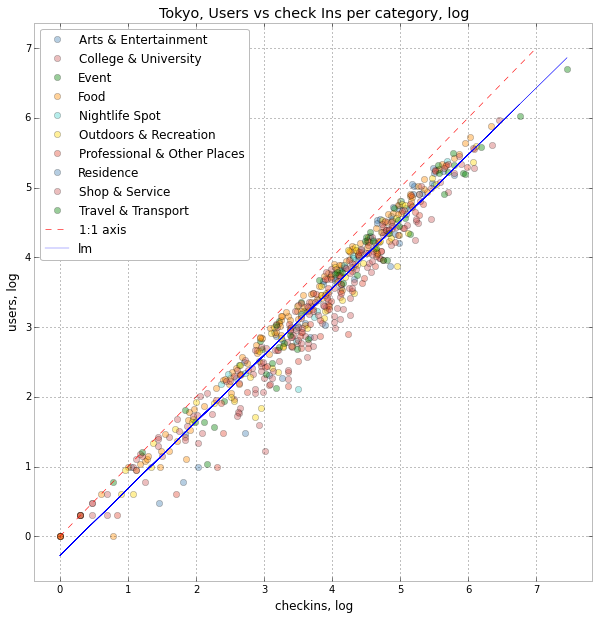

In [41]:
plotLog(tokyo_cat, 'Tokyo')

In [44]:
dfs.keys()

['New_York',
 'Tokyo',
 'Kiev',
 'Mumbai',
 'Moscow',
 'Shanghai',
 'Minsk',
 'Singapur',
 'San Francisco']

('Coefficients: \n', array([[ 0.95944557]]))
Residual sum of squares: 0.05
Variance score: 0.97


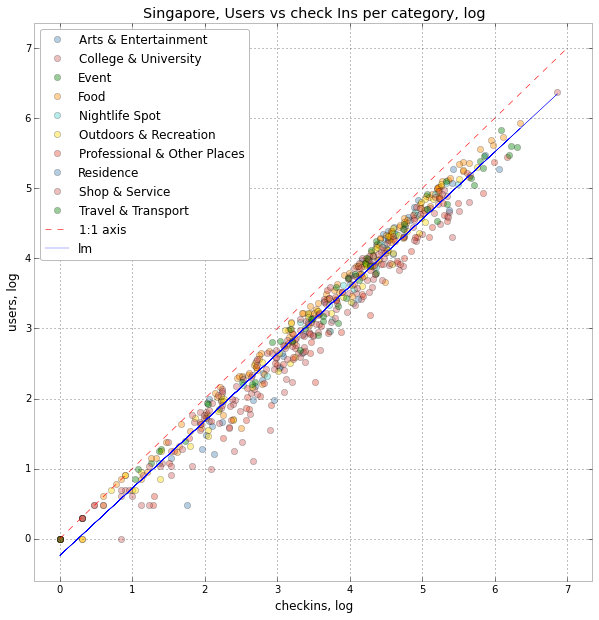

In [79]:
sing_cat = aggData(dfs['Singapur'])
plotLog(sing_cat, 'Singapore')
plt.savefig('/Users/casy/Dropbox/CUSP/project/Square_cities_analysis/ads_project_shared_code/img/log_singapore.png')

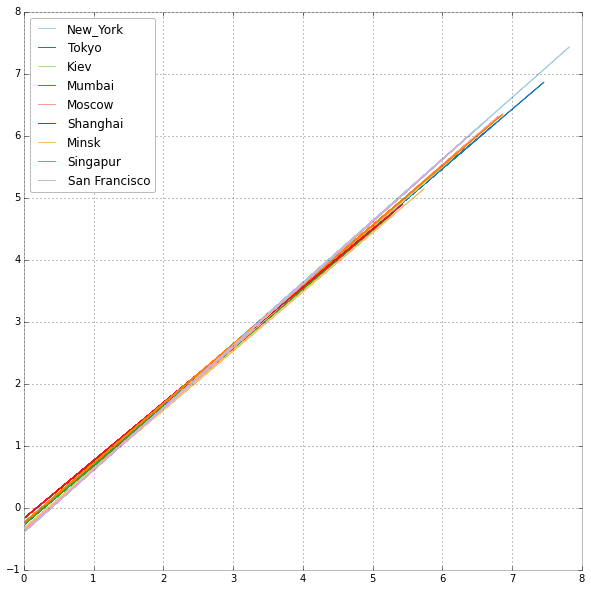

In [72]:
fig, ax = plt.subplots( figsize=(10,10))
results = []

for i, key in enumerate(dfs.keys()):
    df = aggData(dfs[key])
    myLm, X, y = getLogLinears(df, cf=False)
    
    ax.plot(np.sort(X), myLm.predict(np.sort(X)), color=Paired_11.mpl_colors[i],linestyle='-', linewidth=1, label=key)  
    results.append({'name':key, 'coeff':myLm.coef_[0][0], 'res':np.mean((myLm.predict(X) - y) ** 2), 'vscore':myLm.score(X, y)})

plt.legend(loc='best')
plt.savefig('/Users/casy/Dropbox/CUSP/project/Square_cities_analysis/ads_project_shared_code/img/log_comp.png')

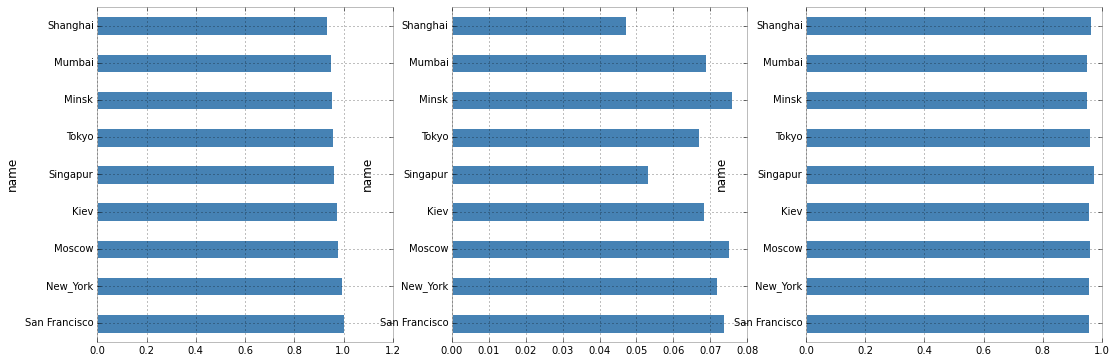

In [89]:
scoreDF = pd.DataFrame(results)[['name','coeff','res','vscore']].sort_values('coeff', ascending=0)
scoreDF.set_index('name',inplace=1)

fig, axes = plt.subplots(1,3, figsize=(18,6))

scoreDF.coeff.plot(kind='barh', ax=axes[0])
scoreDF.res.plot(kind='barh', ax=axes[1])
scoreDF.vscore.plot(kind='barh', ax=axes[2])

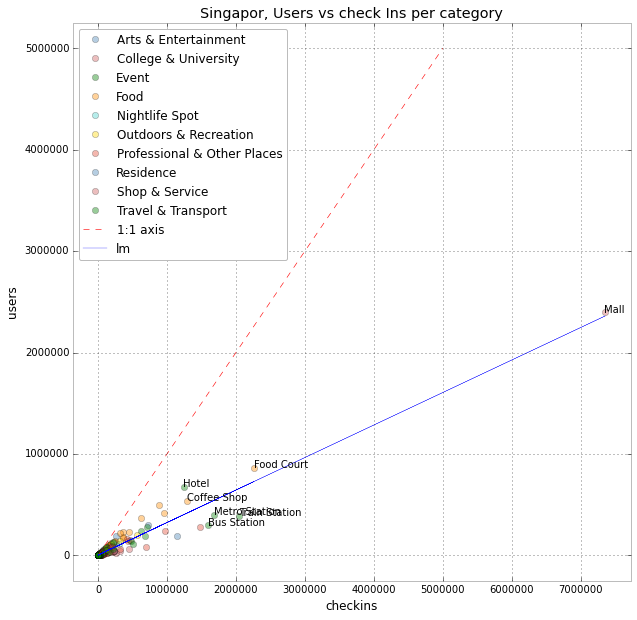

In [106]:
myLm, X = getLinears(sing_cat)
groups = sing_cat.groupby('genCategory')

fig, ax = plt.subplots(figsize=(10,10))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling


for name, group in groups:
    ax.plot(group.checkIns, group.users, marker='o',  linestyle='', ms=6, alpha=.4, label=name)
    annotate_plot(group[(group.users >500000) | (group.checkIns >1500000)], 'category', 'checkIns', 'users')

ax.plot((0,5000000), (0,5000000), color='r', linestyle='--', linewidth=.6,  label='1:1 axis')
ax.plot(X, myLm.predict(X), color='blue',linestyle='-', linewidth=.3, label='lm') 
plt.ylabel('users')    
plt.xlabel('checkins')    
    
plt.title('Singapor, Users vs check Ins per category')
ax.legend(numpoints=1,loc='best');
plt.savefig(PWD + '/img/singapor_cat_sctplt.png')

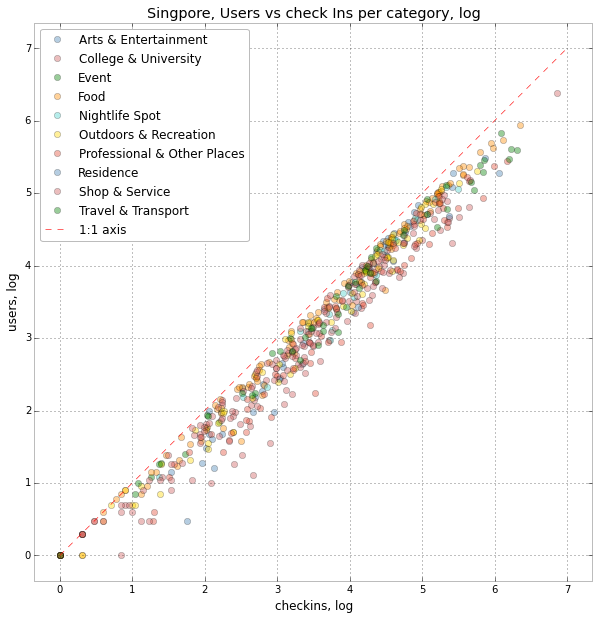

In [88]:
plotLog(sing_cat, 'Singpore')

In [110]:
moscow_cat = aggData(moscow)

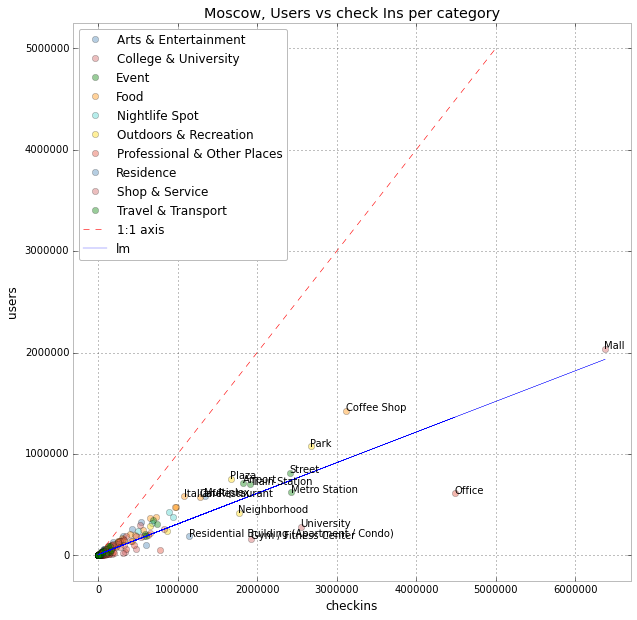

In [115]:
myLm, X = getLinears(moscow_cat)
groups = moscow_cat.groupby('genCategory')

fig, ax = plt.subplots(figsize=(10,10))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling


for name, group in groups:
    ax.plot(group.checkIns, group.users, marker='o',  linestyle='', ms=6, alpha=.4, label=name)
    annotate_plot(group[(group.users >500000) | (group.checkIns > 1000000)], 'category', 'checkIns', 'users')

ax.plot((0,5000000), (0,5000000), color='r', linestyle='--', linewidth=.6,  label='1:1 axis')
ax.plot(X, myLm.predict(X), color='blue',linestyle='-', linewidth=.3,  label='lm') 

plt.ylabel('users')    
plt.xlabel('checkins')    
plt.title('Moscow, Users vs check Ins per category')
ax.legend(numpoints=1,loc='best');
plt.savefig(PWD + '/img/Moscow_cat_sctplt.png')

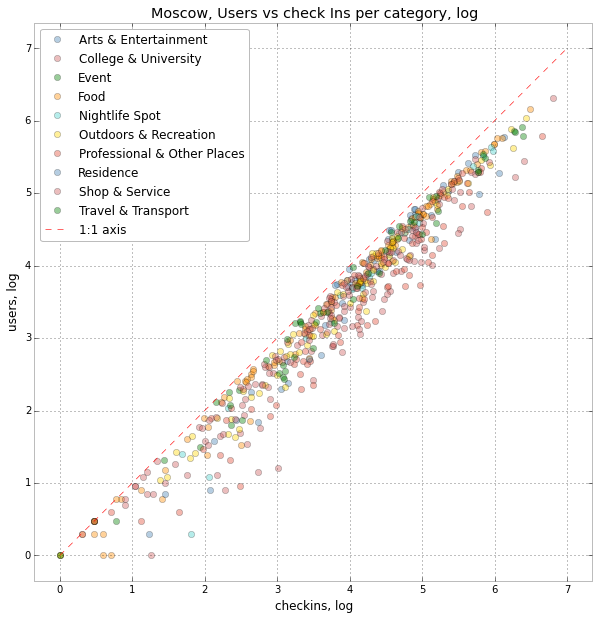

In [116]:
plotLog(moscow_cat, 'Moscow')

In [117]:
sf_path = '/Users/casy/Dropbox/CUSP/project/Square_cities/data/San_Francisco_all.csv' 
sf = pd.read_csv(sf_path, index_col=0, encoding='utf8')[cols]
sf_cat = aggData(sf)

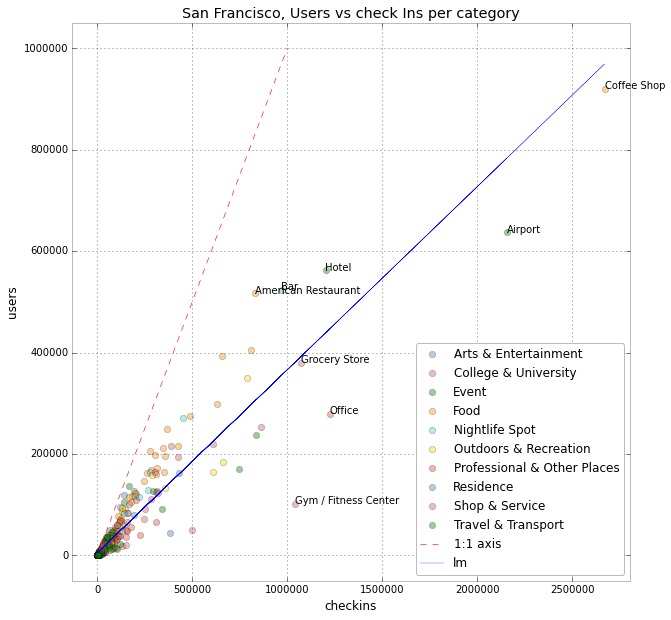

In [121]:
myLm, X = getLinears(sf_cat)
groups = sf_cat.groupby('genCategory')

fig, ax = plt.subplots(figsize=(10,10))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling


for name, group in groups:
    ax.plot(group.checkIns, group.users, marker='o',  linestyle='', ms=6, alpha=.4, label=name)
    annotate_plot(group[(group.users >500000) | (group.checkIns > 1000000)], 'category', 'checkIns', 'users')

ax.plot((0,1000000), (0,1000000), color='r', linestyle='--', linewidth=.6,  label='1:1 axis')
ax.plot(X, myLm.predict(X), color='blue',linestyle='-', linewidth=.3, label='lm') 

plt.ylabel('users')    
plt.xlabel('checkins')    
plt.title('San Francisco, Users vs check Ins per category')
ax.legend(numpoints=1,loc='best');
plt.savefig(PWD + '/img/San_Francisco_cat_sctplt.png')

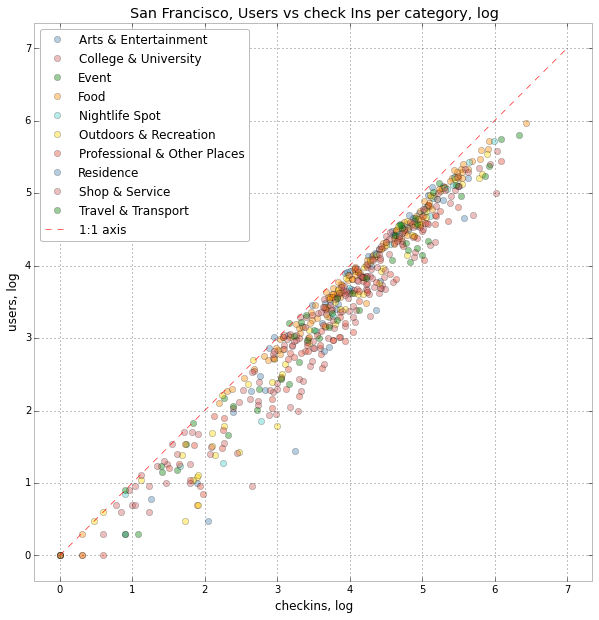

In [122]:
plotLog(sf_cat, 'San Francisco')

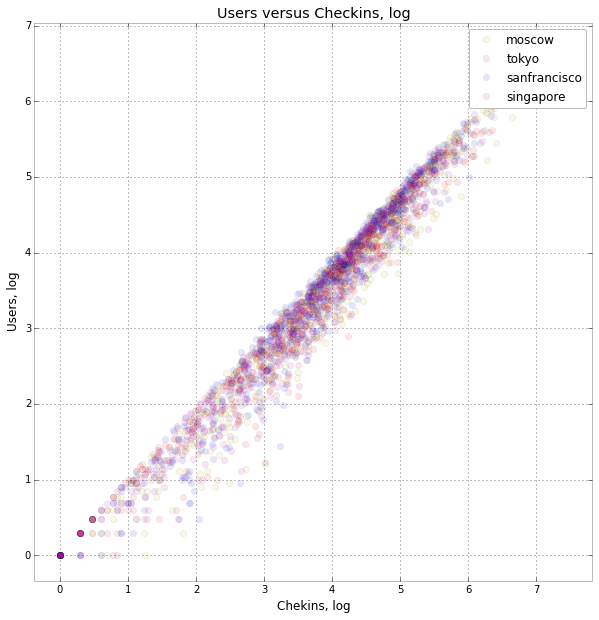

In [140]:
fig, ax = plt.subplots(figsize=(10,10))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

colors =  {'sanfrancisco':'b', 'moscow':'y','singapore':'m', 'tokyo':"r"}

for name, group in {'sanfrancisco':sf_cat, 'moscow':moscow_cat,'singapore':sing_cat, 'tokyo':tokyo_cat}.iteritems():
    ax.plot(np.log10(group.checkIns), np.log10(group.users), marker='o', linestyle='', color=colors[name] ,ms=6, alpha=.1, label=name )


# for name, group in {'sanfrancisco':sf_cat, 'moscow':moscow_cat,'singapore':sing_cat, 'tokyo':tokyo_cat}.iteritems():
#     ax.plot(group.checkIns, group.users, marker='o', linestyle='', color=colors[name] ,ms=6, alpha=.6, label=name )


ax.set_ylabel('Users, log')
ax.set_xlabel('Chekins, log')
ax.set_title('Users versus Checkins, log')

ax.legend(numpoints=1);
plt.savefig(PWD + '/img/all_cat_sctplt_log.png')